## Preprocessing and Modeling

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as pl
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


In [2]:
full_movie_data_clean = pd.read_csv('./data/full_movie_data_clean.csv')

In [3]:
full_movie_data_clean.drop('Unnamed: 0', axis = 1, inplace = True)

In [4]:
full_movie_data_clean.head()

,subreddit,title,post_length
0,1,Scoumoune (1972)Cannot find [this flick](https...,201
1,1,I know it exists somewhereI remember watching ...,365
2,1,Any ideas what this is from?,28
3,1,Family is on a secret reality show (kids/famil...,596
4,1,Pls help me remember my childhoodI remember an...,334


In [5]:
X = full_movie_data_clean['title']
y = full_movie_data_clean['subreddit']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 22)

## Baseline Model

Metric: Accuracy 

50.5% chance of guessing Movie Finder category if we were to guess moviefinder everytime

In [7]:
y_train.value_counts(normalize = True)

1    0.504711
0    0.495289
Name: subreddit, dtype: float64

## Modeling

For all modeling I used gridsearching where I could adjust many parameters. I always used stop_words = english when using countvectorizer or tfidfvectorizer. This eliminated mundane or unimportant words in the hopes of highlighting more unique terms for the subreddits. I tried different groupings of words between 1-3 words because I thought most meaningful groupings would be between 1-3 words. I also did not exceed a max features greater than 800 words for a hyperparameter because I did not want to make an uneven dataframe. Therefore, my max features was a little under half the total rows of the dataframe. I adjused regularization measures for logistic regression and the smoothing effect for naive bayes models. For tree models I did not want to make overfit tree models so a limited the tree depth to 15. Also with the KNeighbors classifer I wanted to avoid overfitting so limited the max neighbors to 50.

## Model 1: Logistic Regression with CountVectorizer

In [8]:
pipe1 = make_pipeline(CountVectorizer(stop_words = 'english'),
                    StandardScaler(with_mean=False), 
                    LogisticRegression())

In [9]:
params1 = {
'countvectorizer__max_features': [25,50,100,800],
'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
'logisticregression__C': [.001, .01, .1, 1, 10, 100]
}


In [10]:
gs_cvect_lrg1 = GridSearchCV(pipe1, params1, n_jobs=-1)
gs_cvect_lrg1.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [25, 50, 100, 800],
                         'countvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)],
                         'logisticregression__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100]})

In [11]:
gs_cvect_lrg1.score(X_train, y_train)

0.9885598923283984

In [12]:
gs_cvect_lrg1.score(X_test, y_test)

0.9415322580645161

In [13]:
gs_cvect_lrg1.best_params_

{'countvectorizer__max_features': 800,
 'countvectorizer__ngram_range': (1, 1),
 'logisticregression__C': 0.1}

In [14]:
gs_cvect_lrg1.best_estimator_

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=800, stop_words='english')),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('logisticregression', LogisticRegression(C=0.1))])

In [15]:
coefs1 = gs_cvect_lrg1.best_estimator_.named_steps['logisticregression'].coef_

In [16]:
features1 = gs_cvect_lrg1.best_estimator_.named_steps['countvectorizer'].get_feature_names()

In [17]:
coef_df1 = pd.DataFrame({'coefs': coefs1[0], 
                        'features': features1})

In [18]:
coef_df1.nlargest(10, 'coefs')

,coefs,features
487,1.030480,movie
333,0.729350,help
575,0.533823,remember
442,0.495769,looking
761,0.464597,watch
400,0.446107,know
350,0.444014,https
193,0.394978,deleted
279,0.370198,free
731,0.364842,tv


In [19]:
coef_df1.nsmallest(10, 'coefs')

,coefs,features
34,-0.513313,2021
32,-0.307863,2019
403,-0.292034,kombat
6,-0.269803,1990
570,-0.251495,reference
538,-0.249564,played
33,-0.243239,2020
631,-0.241518,shown
22,-0.239169,2009
19,-0.227671,2006


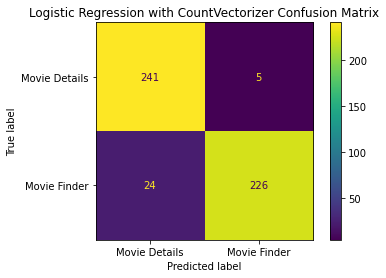

In [20]:
plot_confusion_matrix(gs_cvect_lrg1, X_test, y_test, display_labels = ['Movie Details', 'Movie Finder'])
plt.title('Logistic Regression with CountVectorizer Confusion Matrix');

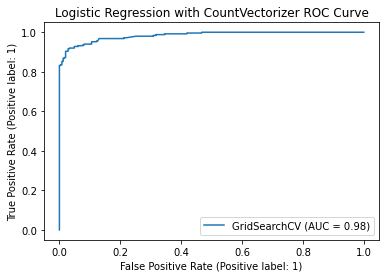

In [21]:
plot_roc_curve(gs_cvect_lrg1, X_test, y_test)
plt.title('Logistic Regression with CountVectorizer ROC Curve');

## Model 2: Logistic Regression with Tfidfvectorizer

In [22]:
pipe2 = make_pipeline(TfidfVectorizer(stop_words = 'english'), 
                     StandardScaler(with_mean=False), 
                     LogisticRegression())
params2 = {
'tfidfvectorizer__max_features': [25,50,100,800],
'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
'logisticregression__C': [.001, .01, .1, 1, 10, 100]
}
gs_tvect_lgr2 = GridSearchCV(pipe2, params2, n_jobs=-1)
gs_tvect_lgr2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100],
                         'tfidfvectorizer__max_features': [25, 50, 100, 800],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]})

In [23]:
gs_tvect_lgr2.score(X_train, y_train)

0.9650067294751009

In [24]:
gs_tvect_lgr2.score(X_test, y_test)

0.9435483870967742

In [25]:
gs_tvect_lgr2.best_params_

{'logisticregression__C': 0.001,
 'tfidfvectorizer__max_features': 800,
 'tfidfvectorizer__ngram_range': (1, 3)}

In [26]:
coefs2 = gs_tvect_lgr2.best_estimator_.named_steps['logisticregression'].coef_

In [27]:
features2 = gs_tvect_lgr2.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names()

In [28]:
coef_df2 = pd.DataFrame({'coefs': coefs2[0], 
                        'features': features2})

In [29]:
coef_df2.nlargest(10, 'coefs')

,coefs,features
563,0.109311,remember
462,0.102672,movie
306,0.085397,help
754,0.082343,watch
421,0.071656,looking
257,0.070670,free
289,0.070251,guy
695,0.067848,think
508,0.063938,online
377,0.061202,know


In [30]:
coef_df2.nsmallest(10, 'coefs')

,coefs,features
33,-0.052585,2021
31,-0.037560,2019
187,-0.036191,director
558,-0.035019,reference
32,-0.033112,2020
527,-0.032976,played
26,-0.032349,2014
16,-0.031282,2004
611,-0.030948,seen
14,-0.030466,2001


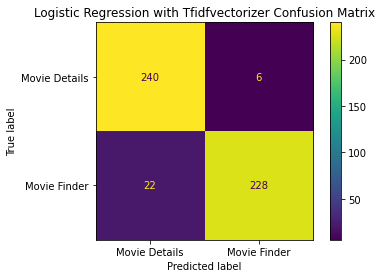

In [31]:
plot_confusion_matrix(gs_tvect_lgr2, X_test, y_test, display_labels = ['Movie Details', 'Movie Finder'])
plt.title('Logistic Regression with Tfidfvectorizer Confusion Matrix');

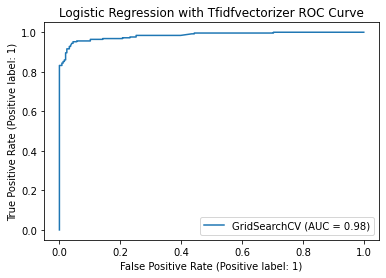

In [32]:
plot_roc_curve(gs_tvect_lgr2, X_test, y_test)
plt.title('Logistic Regression with Tfidfvectorizer ROC Curve');

## Model 3: Naive Bayes with CountVectorizer

In [33]:
pipe3 = make_pipeline(CountVectorizer(stop_words = 'english'), MultinomialNB())

params3 = {
'countvectorizer__max_features': [25,50,100,800],
'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
'multinomialnb__alpha': [0.01, 0.1, 1.0, 10.0]
}

gs_cvect_naive3 = GridSearchCV(pipe3, params3, n_jobs=-1)
gs_cvect_naive3.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [25, 50, 100, 800],
                         'countvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)],
                         'multinomialnb__alpha': [0.01, 0.1, 1.0, 10.0]})

In [34]:
gs_cvect_naive3.score(X_train, y_train)

0.9212651413189771

In [35]:
gs_cvect_naive3.score(X_test, y_test)

0.9193548387096774

In [36]:
gs_cvect_naive3.best_params_

{'countvectorizer__max_features': 800,
 'countvectorizer__ngram_range': (1, 1),
 'multinomialnb__alpha': 1.0}

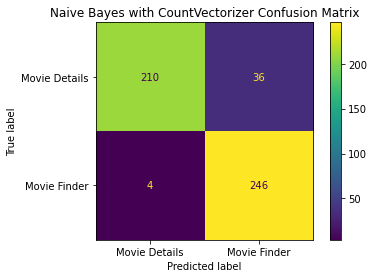

In [37]:
plot_confusion_matrix(gs_cvect_naive3, X_test, y_test, display_labels = ['Movie Details', 'Movie Finder'])
plt.title('Naive Bayes with CountVectorizer Confusion Matrix');

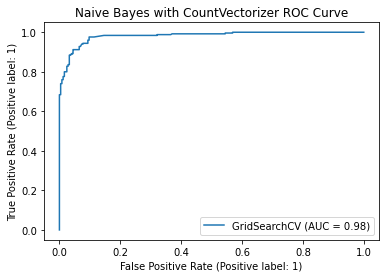

In [38]:
plot_roc_curve(gs_cvect_naive3, X_test, y_test)
plt.title('Naive Bayes with CountVectorizer ROC Curve');

## Model 4: Naive Bayes with Tfidfvectorizer

In [39]:
pipe4 = make_pipeline(TfidfVectorizer(stop_words = 'english'), MultinomialNB())

params4 = {
'tfidfvectorizer__max_features': [25,50,100,800],
'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
'multinomialnb__alpha': [0.01, 0.1, 1.0, 10.0]
}

gs_tvect_naive4 = GridSearchCV(pipe4, params4, n_jobs=-1)
gs_tvect_naive4.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'multinomialnb__alpha': [0.01, 0.1, 1.0, 10.0],
                         'tfidfvectorizer__max_features': [25, 50, 100, 800],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]})

In [40]:
gs_tvect_naive4.score(X_train, y_train)

0.933378196500673

In [41]:
gs_tvect_naive4.score(X_test, y_test)

0.9112903225806451

In [42]:
gs_tvect_naive4.best_params_

{'multinomialnb__alpha': 1.0,
 'tfidfvectorizer__max_features': 800,
 'tfidfvectorizer__ngram_range': (1, 3)}

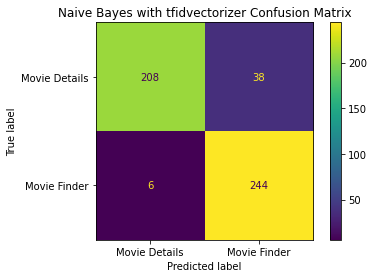

In [43]:
plot_confusion_matrix(gs_tvect_naive4, X_test, y_test, display_labels = ['Movie Details', 'Movie Finder'])
plt.title('Naive Bayes with tfidvectorizer Confusion Matrix');

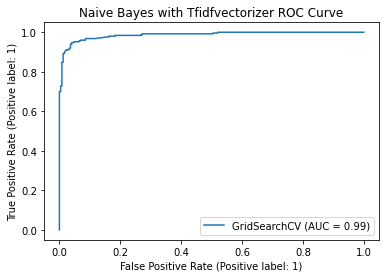

In [44]:
plot_roc_curve(gs_tvect_naive4, X_test, y_test)
plt.title('Naive Bayes with Tfidfvectorizer ROC Curve');

## Model 5: Decision Tree with CountVectorizer 

In [45]:
pipe5 = make_pipeline(CountVectorizer(stop_words = 'english'), DecisionTreeClassifier())

In [46]:
params5 = {
'countvectorizer__max_features': [25,50,800],
'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
'decisiontreeclassifier__max_depth': [5,10,15]}

In [47]:
gs_tree5 = GridSearchCV(pipe5, params5, n_jobs =-1)

In [48]:
gs_tree5.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [25, 50, 800],
                         'countvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)],
                         'decisiontreeclassifier__max_depth': [5, 10, 15]})

In [49]:
gs_tree5.score(X_train, y_train)

0.9535666218034994

In [50]:
gs_tree5.score(X_test, y_test)

0.907258064516129

In [51]:
gs_tree5.best_params_

{'countvectorizer__max_features': 800,
 'countvectorizer__ngram_range': (1, 1),
 'decisiontreeclassifier__max_depth': 10}

In [52]:
feature_importance5 = pd.DataFrame({'importance': gs_tree5.best_estimator_.named_steps['decisiontreeclassifier'].feature_importances_, 'feature': gs_tree5.best_estimator_.named_steps['countvectorizer'].get_feature_names()})

feature_importance5.nlargest(10, 'importance')

In [54]:
feature_importance5.nsmallest(10, 'importance')

,importance,feature
0,0.0,10
1,0.0,12
3,0.0,13
4,0.0,15
6,0.0,1990
7,0.0,1993
8,0.0,1994
9,0.0,1995
10,0.0,1998
11,0.0,20


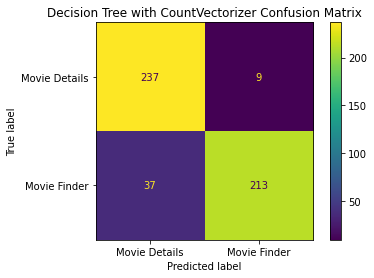

In [55]:
plot_confusion_matrix(gs_tree5, X_test, y_test, display_labels = ['Movie Details', 'Movie Finder'])
plt.title('Decision Tree with CountVectorizer Confusion Matrix');

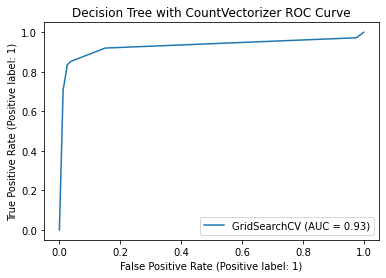

In [56]:
plot_roc_curve(gs_tree5, X_test, y_test)
plt.title('Decision Tree with CountVectorizer ROC Curve');

## Model 6: Decision Tree with Tfidfvectorizer

In [57]:
pipe6 = make_pipeline(TfidfVectorizer(stop_words = 'english'), DecisionTreeClassifier())


params6 = {
'tfidfvectorizer__max_features': [25,50,100,800],
'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
'decisiontreeclassifier__max_depth': [5,10,15]}

gs_tree6 = GridSearchCV(pipe6, params6, n_jobs =-1)

gs_tree6.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [5, 10, 15],
                         'tfidfvectorizer__max_features': [25, 50, 100, 800],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]})

In [58]:
gs_tree6.score(X_train, y_train)

0.9522207267833109

In [59]:
gs_tree6.score(X_test, y_test)

0.905241935483871

In [60]:
gs_tree6.best_params_

{'decisiontreeclassifier__max_depth': 10,
 'tfidfvectorizer__max_features': 800,
 'tfidfvectorizer__ngram_range': (1, 1)}

In [61]:
feature_importance6 = pd.DataFrame({'importance': gs_tree6.best_estimator_.named_steps['decisiontreeclassifier'].feature_importances_, 'feature': gs_tree6.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names()})

In [62]:
feature_importance6.nlargest(10, 'importance')

,importance,feature
487,0.455966,movie
575,0.142431,remember
490,0.083577,movies
333,0.067096,help
442,0.044354,looking
266,0.023382,films
400,0.019603,know
761,0.016861,watch
703,0.015116,think
727,0.012125,trying


In [63]:
feature_importance6.nsmallest(10, 'importance')

,importance,feature
0,0.0,10
1,0.0,12
3,0.0,13
4,0.0,15
5,0.0,1985
6,0.0,1990
7,0.0,1993
8,0.0,1994
9,0.0,1995
10,0.0,1998


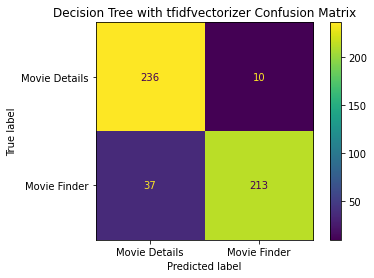

In [64]:
plot_confusion_matrix(gs_tree6, X_test, y_test, display_labels = ['Movie Details', 'Movie Finder'])
plt.title('Decision Tree with tfidfvectorizer Confusion Matrix');

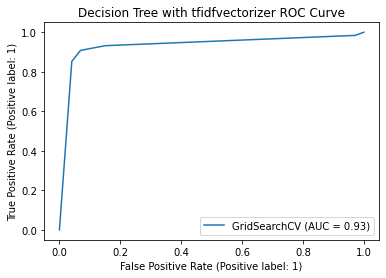

In [65]:
plot_roc_curve(gs_tree6, X_test, y_test)
plt.title('Decision Tree with tfidfvectorizer ROC Curve');

## Model 7: Random Forest and Extra Trees 

Max features of 800 and tfidvectorizer seem to be performing best on other models will use them to look at random forest and extra trees to see if random forest or extra trees performs better and then doing a larger grid search on the winner.

In [66]:
forest_pipe = make_pipeline(TfidfVectorizer(stop_words = 'english', max_features = 800), RandomForestClassifier(max_depth = 10))
extra_pipe = make_pipeline(TfidfVectorizer(stop_words = 'english', max_features = 800), ExtraTreesClassifier(max_depth = 10))

In [67]:
forest_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=800, stop_words='english')),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10))])

In [68]:
forest_pipe.score(X_train, y_train)

0.9374158815612382

In [69]:
forest_pipe.score(X_test, y_test)

0.907258064516129

In [70]:
extra_pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=800, stop_words='english')),
                ('extratreesclassifier', ExtraTreesClassifier(max_depth=10))])

In [71]:
extra_pipe.score(X_train, y_train)

0.9340511440107672

In [72]:
extra_pipe.score(X_test, y_test)

0.8870967741935484

Forest pipe performing better than extra pipe will do a gridsearch on forest pipe

In [73]:
forest_pipe7 = make_pipeline(TfidfVectorizer(stop_words = 'english'), RandomForestClassifier())

params7 = {
'tfidfvectorizer__max_features': [25,50,100,800],
'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
'randomforestclassifier__max_depth': [5,10,15]}

forest_grid7 = GridSearchCV(forest_pipe7, params7, n_jobs = -1)

forest_grid7.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [5, 10, 15],
                         'tfidfvectorizer__max_features': [25, 50, 100, 800],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]})

In [74]:
forest_grid7.score(X_train, y_train)

0.9616419919246298

In [75]:
forest_grid7.score(X_test, y_test)

0.9254032258064516

In [76]:
forest_grid7.best_params_

{'randomforestclassifier__max_depth': 15,
 'tfidfvectorizer__max_features': 800,
 'tfidfvectorizer__ngram_range': (1, 1)}

In [77]:
feature_importances = forest_grid7.best_estimator_.named_steps['randomforestclassifier'].feature_importances_

In [78]:
names = forest_grid7.best_estimator_['tfidfvectorizer'].get_feature_names()

In [79]:
feature_importance7 = pd.DataFrame({'importances':feature_importances, 'names': names}).sort_values(by = 'importances', ascending = False)

In [80]:
feature_importance7.nlargest(10, 'importances')

,importances,names
487,0.101883,movie
575,0.083994,remember
333,0.081484,help
703,0.034442,think
313,0.030183,guy
442,0.026885,looking
400,0.026130,know
292,0.023628,girl
426,0.021552,like
727,0.020921,trying


In [81]:
feature_importance7.nsmallest(10, 'importances')

,importances,names
251,0.0,falls
3,0.0,13
323,0.0,happy
324,0.0,hard
793,0.0,yellow
4,0.0,15
24,0.0,2011
298,0.0,glasses
216,0.0,drama
318,0.0,hands


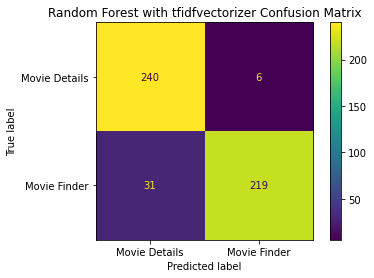

In [82]:
plot_confusion_matrix(forest_grid7, X_test, y_test, display_labels = ['Movie Details', 'Movie Finder'])
plt.title('Random Forest with tfidfvectorizer Confusion Matrix');

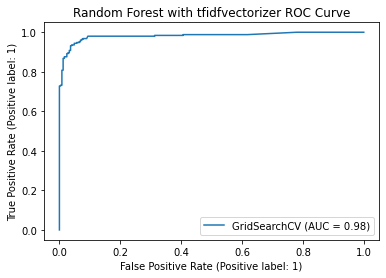

In [83]:
plot_roc_curve(forest_grid7, X_test, y_test)
plt.title('Random Forest with tfidfvectorizer ROC Curve');

## Model 8: KNN

In [84]:
pipe8 = make_pipeline(TfidfVectorizer(stop_words = 'english'), KNeighborsClassifier())


params8 = {
'tfidfvectorizer__max_features': [25,50,100,800],
'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
'kneighborsclassifier__n_neighbors': [5,10,20,50]}

gs_knn8 = GridSearchCV(pipe8, params8, n_jobs =-1)

gs_knn8.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [5, 10, 20, 50],
                         'tfidfvectorizer__max_features': [25, 50, 100, 800],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]})

In [85]:
gs_knn8.score(X_train, y_train)

0.882907133243607

In [86]:
gs_knn8.score(X_test, y_test)

0.8770161290322581

In [87]:
gs_knn8.best_params_

{'kneighborsclassifier__n_neighbors': 5,
 'tfidfvectorizer__max_features': 25,
 'tfidfvectorizer__ngram_range': (1, 1)}

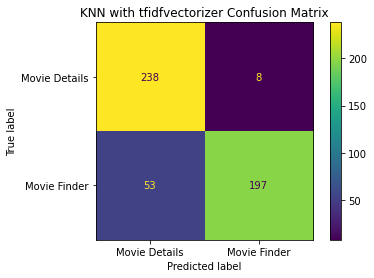

In [88]:
plot_confusion_matrix(gs_knn8, X_test, y_test, display_labels = ['Movie Details', 'Movie Finder'])
plt.title('KNN with tfidfvectorizer Confusion Matrix');

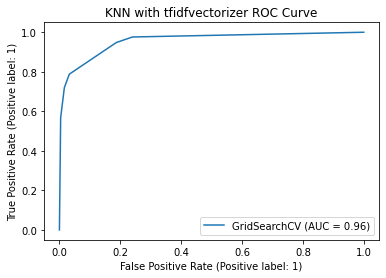

In [89]:
plot_roc_curve(gs_knn8, X_test, y_test)
plt.title('KNN with tfidfvectorizer ROC Curve');

## Summary of Models with Best Model being Logistic Regression with Tfidfvectorizer

1) Logistic Regression with CountVectorizer: 

    Train Score: 0.989
    
    Test Score: 0.941
2) Logistic Regression with TfidfVectorizer:

    Train Score: 0.965
    
    Test Score: 0.944
3) Naive Bayes with CountVectorizer:

    Train Score: 0.921
    
    Test Score: 0.919
4) Naive Bayes with TfidfVectorizer:

    Train Score: 0.933
    
    Test Score: 0.911
5) Decision Tree with CountVectorizer:

    Train Score: 0.954
    
    Test Score: 0.907
6) Decision Tree with TfidfVectorizer:

    Train Score: 0.976
    
    Test Score: 0.903
7) Random Forest with TfidfVectorizer:

    Train Score: 0.956
    
    Test Score: 0.931
8) KNeighbors Classifier with TfidfVectorizer:

    Train Score: 0.883
    
    Test Score: 0.877

As we can see from the summary above that logistic regression with tfidvectorizer outperformed the other models with a test score of 0.944. Also the test score of 0.944 was close to the train score of 0.965 showing that this model is not overfit. The other models all performed over the baseline score of 50.5%. Random forest with tfidvectorizer and logistic regression with countvectorizer also demonstrated impressive accuracy scores with 0.931 and 0.941 respectively. Below is outline of the best params used to obtain the accuracy test score of 0.944 from logistic regression with tfidvectorizer.

#### Summary of Parameters
Logistic Regression with Tfidfvectorizer

{'logisticregression__C': 0.001,

 'tfidfvectorizer__max_features': 800,
 
 'tfidfvectorizer__ngram_range': (1, 3)}



train accuracy score :

0.9650067294751009

test accuracy score: 

0.0.9435483870967742